In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
from torchsummary import summary


ModuleNotFoundError: ignored

# training a model first

In [ ]:
use_cuda = True
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



In [ ]:
class NetTest(nn.Module):
    def __init__(self, im_res=28, conv1_size=5, conv2_size=5, pool1_size=2, pool2_size=2, num_conv1=10, num_conv2=10, num_hid=50):
        super(NetTest, self).__init__()
        # import pdb; pdb.set_trace()
        self.conv1 = nn.Conv2d(1, num_conv1, kernel_size=conv1_size)
        self.res1 = int((im_res - conv1_size + 2*0) / 1 + 1)
        self.conv2 = nn.Conv2d(num_conv1, num_conv2, kernel_size=conv2_size)
        self.res2_pool = int((self.res1 - pool1_size + 2*0) / pool1_size + 1)                
        self.res2_conv = int((self.res2_pool - conv2_size + 2*0) / 1 + 1 )       
        self.res2_pool = int((self.res2_conv - pool2_size + 2*0) / pool2_size + 1)               
        self.conv2_drop = nn.Dropout2d()

        # self.fc1 = nn.Linear(num_conv2, num_hid)

        self.fc1 = nn.Linear((self.res2_pool**2)*num_conv2, num_hid)        
        self.fc2 = nn.Linear(num_hid, 10)
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.num_conv2 = num_conv2
        self.im_res = im_res

        
    def forward(self, x):
        # import pdb; pdb.set_trace()
        x = F.avg_pool2d(x, kernel_size=28//self.im_res)

        tmp1 = F.relu(F.max_pool2d(self.conv1(x), self.pool1_size))
        tmp = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(tmp1)), self.pool2_size))
        # x = F.avg_pool2d(tmp, kernel_size=tmp.shape[-1])
        # x = x[:,:,0,0]

        x = tmp.view(-1, (self.res2_pool**2)*self.num_conv2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x   ### SUPER IMPORTANT ***************************** works with cross entropy loss loss now

device = 'cuda'

In [ ]:
aa = nn.Linear(10,2, bias = True)
inp = torch.tensor(np.random.random((1,10)), dtype=torch.float)
# aa()
# F.avg_pool2d?

In [ ]:
inp.shape
# aa(inp)
aa.in_features

10

In [ ]:
def train_model(model):

  EPOCHS = 10
  losses = []

  optimizer = optim.Adadelta(model.parameters())

  model.train()
  for epoch in range(EPOCHS):
      for batch_idx, (data, target) in enumerate(train_loader):
          
          data, target = data.to(device), target.to(device)        
          optimizer.zero_grad()
          y_pred = model(data) 

          # import pdb; pdb.set_trace()
          loss = F.cross_entropy(y_pred, target)
          losses.append(loss.cpu().data)

          loss.backward()
          optimizer.step()
          
          # Display
          if batch_idx % 100 == 1:
              print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data), 
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')

  # Eval
  model.eval()
  evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor()).to(device)
  evaluate_y = test_loader.dataset.test_labels.to(device)

  output = model(evaluate_x[:,None,...])
  pred = output.data.max(1)[1]
  d = pred.eq(evaluate_y.data).cpu()
  accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
  
  print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
      epoch+1,
      EPOCHS,
      len(train_loader.dataset), 
      len(train_loader.dataset),
      100. * batch_idx / len(train_loader), 
      loss.cpu().data,
      accuracy*100,
      end=''))
  

  return accuracy

In [ ]:
import warnings
warnings.filterwarnings("ignore")

accuracies = []
for im_size in [7,14,28]:
  for cv1_size in [2,3,5]:
    for cv2_size in [2,3,5]:
      for pl1_size in [1,2]:  
        for pl2_size in [1,2]:        
          try:
            print(f'----  im_res={im_size}, conv1_size={cv1_size}, conv2_size={cv2_size}, pool1_size={pl1_size}, pool2_size={pl2_size}')
            model = NetTest(im_res=im_size, conv1_size=cv1_size, conv2_size=cv2_size, pool1_size=pl1_size, pool2_size=pl2_size).to(device)
            # model = NetTest(im_res=im_size, conv1_size=3, conv2_size=3, pool1_size=1, pool2_size=1).to(device)            
            # model = NetTest(im_res=im_size).to(device)            
            macs, params = profile(model, inputs=(torch.randn(1, 1, 28, 28).to(device), ))
            acc = train_model(model)
            accuracies.append((im_size, cv1_size, cv2_size, pl1_size, pl2_size, macs, params, acc.item()))
            print(accuracies[-1])

          except:
            print('\n Model invalid')


----  im_res=7, conv1_size=2, conv2_size=2, pool1_size=1, pool2_size=1
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.NetTest'>. Treat it as zero Macs and zero Params.
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.904763	 Test Accuracy: 63.6900%
(7, 2, 2, 1, 1, 25050.0, 13520.0, 0.6369)
----  im_res=7, conv1_size=2, conv2_size=2, pool1_size=1, pool2_size=2
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.NetTest'>. Treat it as zero Macs and zero Params.
 Train Epoch: 1

Exception ignored in: <bound method ZipFile.__del__ of <zipfile.ZipFile [closed]>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/zipfile.py", line 1686, in __del__
    self.close()
  File "/usr/lib/python3.6/zipfile.py", line 1703, in close
    self.fp.seek(self.start_dir)
ValueError: I/O operation on closed file.


 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.805044	 Test Accuracy: 75.9800%
(7, 3, 2, 1, 1, 17560.0, 9070.0, 0.7598)
----  im_res=7, conv1_size=3, conv2_size=2, pool1_size=1, pool2_size=2
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.NetTest'>. Treat it as zero Macs and zero Params.
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.876265	 Test Accuracy: 69.0000%
(7, 3, 2, 1, 2, 11560.0, 3070.0, 0.69)
----  im_res=7, conv1_size=3, conv2_size=2, pool1_size=2, pool2_size=1
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.L

In [ ]:
cc(im_size, cv1_size, cv2_size, pl1_size, pl2_size, acc.item())

In [ ]:
res = 7
model = NetTest(im_res=res, conv1_size=5, conv2_size=2, pool1_size=1, pool2_size=1).to(device)  # training with slope 1 for now
# model = NetTest(im_res=7, conv1_size=2, conv2_size=2, pool1_size=1, pool2_size=1).to(device)
model
summary(model, (1, res, res))

In [ ]:
model.res2_pool*model.num_conv2

In [ ]:
# counting flops
# https://github.com/Lyken17/pytorch-OpCounter
# !pip install thop

# from torchvision.models import resnet50
# from thop import profile
# # model = resnet50()
# # input = torch.randn(1, 3, 224, 224)
# input = torch.randn(1, 1, 28, 28).to(device)
# macs, params = profile(model, inputs=(input, ))


In [ ]:
macs

In [ ]:
# FLOPS
# http://www.bnikolic.co.uk/blog/python/flops/2019/10/01/pytorch-count-flops.html

In [ ]:
# evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor())
# evaluate_y = test_loader.dataset.test_labels

# data, target = data.to(device), target.to(device)        

# model.eval()
# output, cv1, cv2 = model(evaluate_x[:,None,...])
# pred = output.data.max(1)[1]
# d = pred.eq(evaluate_y.data).cpu()
# accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

# print('Accuracy:', accuracy*100)

In [ ]:
accs = np.array(accuracies)

In [ ]:
# accs[:,[1,5,6,7]]
score = accs[:,7]
pars = accs[:,5]
flops = accs[:,6]
ress = accs[:,0]

In [ ]:
from matplotlib import pyplot as plt

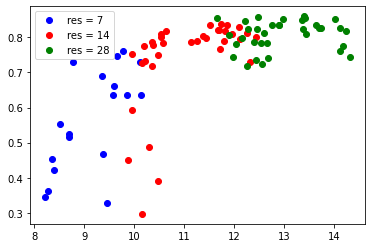

In [ ]:
colors = ['blue', 'red', 'green', ]
for idx,i in enumerate([7,14,28]):
  plt.plot(np.log(pars[ress==i]), score[ress==i] , 'o', color = colors[idx])

plt.legend(['res = 7', 'res = 14', 'res = 28'])

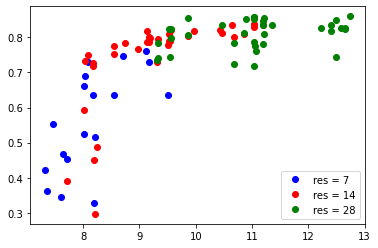

In [ ]:
colors = ['blue', 'red', 'green', ]
for idx,i in enumerate([7,14,28]):
  plt.plot(np.log(flops[ress==i]), score[ress==i] , 'o', color = colors[idx])

plt.legend(['res = 7', 'res = 14', 'res = 28'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ls MyDrive/

In [ ]:
cd drive/

/content/drive


In [ ]:
# cd /MyDrive/classification_images/Pairwise
!cd MyDrive/ClassificationImages/Pairwise/

In [ ]:
# from google.colab import files
# # 
# with open('example.txt', 'w') as f:
#   f.write('some content')

# files.download('example.txt')



# with open('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz', 'w') as f:
np.savez('MyDrive/ClassificationImages/Pairwise/accs_fmnist.npz', accs)


In [ ]:
# with open('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz') as f:
dd = np.load('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz')

In [ ]:
# accs = dd['arr_0']

In [ ]:
# accs

array([[7.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00,
        2.50500e+04, 1.35200e+04, 9.25400e-01],
       [7.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00,
        1.45500e+04, 3.02000e+03, 8.24900e-01],
       [7.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00,
        5.94000e+03, 3.02000e+03, 8.22200e-01],
       [7.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00,
        4.44000e+03, 1.52000e+03, 5.89900e-01],
       [7.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00,
        2.48600e+04, 9.52000e+03, 9.09700e-01],
       [7.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        1.88600e+04, 3.52000e+03, 8.75500e-01],
       [7.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00,
        3.71000e+03, 2.02000e+03, 4.58200e-01],
       [7.00000e+00, 2.00000e+00, 5.00000e+00, 1.00000e+00, 1.00000e+00,
        1.43400e+04, 5.12000e+03, 9.21000e-01],
       [7.00000e+00, 2.00000e+00